In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/dengai-dataset/DengAI_Predicting_Disease_Spread_-_Test_Data_Features.csv
/kaggle/input/dengai-dataset/DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv
/kaggle/input/dengai-dataset/DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv
/kaggle/input/dengai-dataset/DengAI_Predicting_Disease_Spread_-_Submission_Format.csv


In [92]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [93]:
feature_data=pd.read_csv('../input/dengai-dataset/DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv')
feature_data.head()
feature_data.dtypes

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [94]:
case_data=pd.read_csv('../input/dengai-dataset/DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv')
case_data.head()


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [95]:
case_data.dtypes

city           object
year            int64
weekofyear      int64
total_cases     int64
dtype: object

In [96]:
feature_data['week_start_date']=pd.to_datetime(feature_data['week_start_date'],format='%Y-%m-%d')
feature_data['yearweek']= feature_data['year'].astype(str) + feature_data['weekofyear'].astype(str)
case_data['yearweek']= case_data['year'].astype(str) + case_data['weekofyear'].astype(str)


In [97]:
print(case_data)
case_data.dtypes
feature_data.dtypes
training_data = pd.merge(feature_data,case_data[['city','total_cases','yearweek']], how='left',on=['city','yearweek'])
training_data.head()

     city  year  weekofyear  total_cases yearweek
0      sj  1990          18            4   199018
1      sj  1990          19            5   199019
2      sj  1990          20            4   199020
3      sj  1990          21            3   199021
4      sj  1990          22            6   199022
...   ...   ...         ...          ...      ...
1451   iq  2010          21            5   201021
1452   iq  2010          22            8   201022
1453   iq  2010          23            1   201023
1454   iq  2010          24            1   201024
1455   iq  2010          25            4   201025

[1456 rows x 5 columns]


city           object
year            int64
weekofyear      int64
total_cases     int64
yearweek       object
dtype: object

city                                             object
year                                              int64
weekofyear                                        int64
week_start_date                          datetime64[ns]
ndvi_ne                                         float64
ndvi_nw                                         float64
ndvi_se                                         float64
ndvi_sw                                         float64
precipitation_amt_mm                            float64
reanalysis_air_temp_k                           float64
reanalysis_avg_temp_k                           float64
reanalysis_dew_point_temp_k                     float64
reanalysis_max_air_temp_k                       float64
reanalysis_min_air_temp_k                       float64
reanalysis_precip_amt_kg_per_m2                 float64
reanalysis_relative_humidity_percent            float64
reanalysis_sat_precip_amt_mm                    float64
reanalysis_specific_humidity_g_per_kg           

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,yearweek,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,199018,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,199019,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,199020,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,199021,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,199022,6


In [98]:
is_sj = training_data.city == 'sj'
sj_training_data=training_data[is_sj]
sj_training_data.head()
sj_training_data.describe()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,yearweek,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,199018,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,199019,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,199020,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,199021,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,199022,6


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,936.000000,936.000000,745.000000,887.000000,917.000000,917.000000,927.000000,930.000000,930.000000,930.000000,...,930.000000,927.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,936.000000
mean,1998.826923,26.503205,0.057925,0.067469,0.177655,0.165956,35.470809,299.163653,299.276920,295.109519,...,78.568181,35.470809,16.552409,2.516267,27.006528,6.757373,31.607957,22.600645,26.785484,34.180556
std,5.212076,15.021909,0.107153,0.092479,0.057166,0.056073,44.606137,1.236429,1.218637,1.569943,...,3.389488,44.606137,1.560923,0.498892,1.415473,0.835993,1.717297,1.506277,29.325811,51.381372
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,295.938571,296.114286,289.642857,...,66.735714,0.000000,11.715714,1.357143,22.842857,4.528571,26.700000,17.800000,0.000000,0.000000
25%,1994.000000,13.750000,0.004500,0.016425,0.139283,0.129157,0.000000,298.195000,298.300000,293.847857,...,76.246071,0.000000,15.236429,2.157143,25.842857,6.200000,30.600000,21.700000,6.825000,9.000000
50%,1999.000000,26.500000,0.057700,0.068075,0.177186,0.165971,20.800000,299.254286,299.378571,295.464286,...,78.667857,20.800000,16.845714,2.457143,27.228571,6.757143,31.700000,22.800000,17.750000,19.000000
75%,2003.000000,39.250000,0.111100,0.115200,0.212557,0.202771,52.180000,300.132857,300.228571,296.418929,...,80.963214,52.180000,17.858571,2.800000,28.185714,7.285714,32.800000,23.900000,35.450000,37.000000
max,2008.000000,53.000000,0.493400,0.437100,0.393129,0.381420,390.600000,302.200000,302.164286,297.795714,...,87.575714,390.600000,19.440000,4.428571,30.071429,9.914286,35.600000,25.600000,305.900000,461.000000


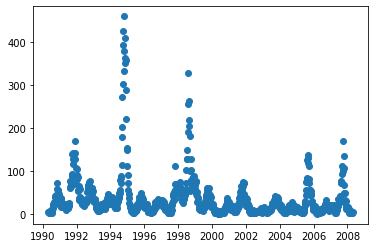

In [99]:
plt.scatter(sj_training_data['week_start_date'], sj_training_data['total_cases'])
plt.show()

In [100]:
sj_training_data.dtypes

city                                             object
year                                              int64
weekofyear                                        int64
week_start_date                          datetime64[ns]
ndvi_ne                                         float64
ndvi_nw                                         float64
ndvi_se                                         float64
ndvi_sw                                         float64
precipitation_amt_mm                            float64
reanalysis_air_temp_k                           float64
reanalysis_avg_temp_k                           float64
reanalysis_dew_point_temp_k                     float64
reanalysis_max_air_temp_k                       float64
reanalysis_min_air_temp_k                       float64
reanalysis_precip_amt_kg_per_m2                 float64
reanalysis_relative_humidity_percent            float64
reanalysis_sat_precip_amt_mm                    float64
reanalysis_specific_humidity_g_per_kg           

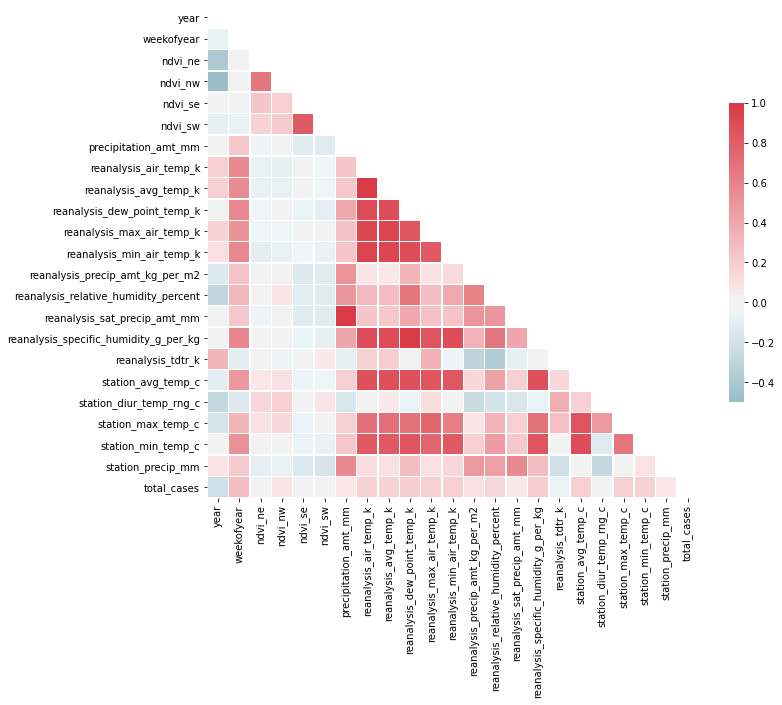

In [117]:
#generating correlation matrix for sj data
sj_corr=sj_training_data.corr()
ax = plt.subplots(figsize=(11,11))
mask = np.triu(np.ones_like(sj_corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Drawing the heatmap 
sns.heatmap(sj_corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5});
#matfig=plt.figure(figsize=(12,12))
#plt.matshow(sj_corr.corr(),aspect='auto',fignum=matfig.number)
#plt.xticks(range(len(sj_corr.columns)),sj_corr.columns, rotation='vertical')
#plt.yticks(range(len(sj_corr.columns)),sj_corr.columns)
#plt.margins(0.2)
#plt.colorbar()
#plt.show();


In [ ]:
#creating a subset from sj_training_data to be used in fbprohet model
sj_model_data= sj_training_data.iloc[:,[3,25]]
sj_model_data.columns=["ds","y"]
sj_model_data.tail()
sj_prophet=Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')
sj_prophet.fit(sj_model_data)
#help(Prophet.make_future_dataframe)
sj_prop_future= sj_prophet.make_future_dataframe(freq='W',periods=260)
sj_prop_future.tail()
sj_prop_forecast= sj_prophet.predict(sj_prop_future)
sj_prop_forecast.tail()
plot1 = sj_prophet.plot(sj_prop_forecast)
plot2 = sj_prophet.plot_components(sj_prop_forecast)

In [119]:
help(pd.DataFrame)
sj_test_forecast=pd.DataFrame(dict(city="sj",ds=sj_prop_forecast['ds'], yhat=sj_prop_forecast['yhat']))
sj_test_forecast.tail()
sj_predicted=sj_test_forecast.iloc[936:1196,]
sj_predicted.shape
sj_predicted.columns=["city","ds","total_cases"]
sj_predicted.tail()

Help on class DataFrame in module pandas.core.frame:

class DataFrame(pandas.core.generic.NDFrame)
 |  Two-dimensional size-mutable, potentially heterogeneous tabular data
 |  structure with labeled axes (rows and columns). Arithmetic operations
 |  align on both row and column labels. Can be thought of as a dict-like
 |  container for Series objects. The primary pandas data structure.
 |  
 |  Parameters
 |  ----------
 |  data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
 |      Dict can contain Series, arrays, constants, or list-like objects
 |  
 |      .. versionchanged :: 0.23.0
 |         If data is a dict, column order follows insertion-order for
 |         Python 3.6 and later.
 |  
 |      .. versionchanged :: 0.25.0
 |         If data is a list of dicts, column order follows insertion-order
 |         for Python 3.6 and later.
 |  
 |  index : Index or array-like
 |      Index to use for resulting frame. Will default to RangeIndex if
 |      no indexin

,city,ds,yhat
1191,sj,2013-03-17,-16.490303
1192,sj,2013-03-24,-20.784494
1193,sj,2013-03-31,-22.755732
1194,sj,2013-04-07,-22.844209
1195,sj,2013-04-14,-22.974892


(260, 3)

,city,ds,total_cases
1191,sj,2013-03-17,-16.490303
1192,sj,2013-03-24,-20.784494
1193,sj,2013-03-31,-22.755732
1194,sj,2013-04-07,-22.844209
1195,sj,2013-04-14,-22.974892


In [ ]:
#IQ's analysis
is_iq = training_data.city == 'iq'
iq_training_data=training_data[is_iq]
iq_training_data.head()
iq_training_data.describe()

In [ ]:
iq_model_data= iq_training_data.iloc[:,[3,25]]
iq_model_data.columns=["ds","y"]
iq_model_data.tail()
iq_prophet=Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')
iq_prophet.fit(iq_model_data)
#help(Prophet.make_future_dataframe)
iq_prop_future= iq_prophet.make_future_dataframe(freq='W',periods=156)
iq_prop_future.tail()
iq_prop_forecast= iq_prophet.predict(iq_prop_future)
iq_prop_forecast.tail()
plot1 = iq_prophet.plot(iq_prop_forecast)
plot2 = iq_prophet.plot_components(iq_prop_forecast)

In [ ]:
iq_test_forecast=pd.DataFrame(dict(city="iq",ds=iq_prop_forecast['ds'], yhat=iq_prop_forecast['yhat']))
iq_test_forecast.tail()
iq_predicted=iq_test_forecast.iloc[520:676,]
iq_predicted.shape
iq_predicted.columns=["city","ds","total_cases"]
iq_predicted.tail()

In [ ]:
result=sj_predicted.append(iq_predicted)
result.head()
result.shape

In [ ]:
result.to_csv('result-v1.csv')